# 최고모델 찾기

In [25]:
import itertools
import pickle
import pathlib

##############################################
PETG_PKL_PATH = r"output\MODE2\ANN_2023_10_26_165137.pkl"  # PETG만 학습
TRANSFER_1_PKL_PATH = (
    r"output\mode_a_1\ANN_2023_10_27_114715.pkl"  # PETG만 학습
)
TRANSFER_2_PKL_PATH = (
    r"output\mode_a_1_2\ANN_2023_10_27_115118.pkl"  # PETG만 학습
)
TRANSFER_3_PKL_PATH = (
    r"output\mode_a_1_2_3\ANN_2023_10_27_115403.pkl"  # PETG만 학습
)

N_BEST_MODELS = 5
##############################################


def find_files_with_pattern(params, pkl_file_path):
    # 모든 순서 조합을 위한 패턴 생성
    patterns = [
        "".join([f"[{key.upper()}={value}]" for key, value in perm])
        for perm in itertools.permutations(params.items())
    ]

    # 현재 폴더에서 .keras로 끝나는 모든 파일을 검사
    folder = pathlib.Path(pkl_file_path).parent
    matched_files = set(
        str(file)
        for file in folder.glob("*.keras")
        for pattern in patterns
        if pattern in file.name
    )

    return list(matched_files)


def extract_hyper_params_and_best_loss(data, loss_type):
    hyper_params = data["train_input"]["hyper_params"]
    losses = data["train_output"]
    return hyper_params, min(losses[loss_type])


def show_n_best_models(pkl_file_path, loss_type):
    print(f"=========== {pkl_file_path} ============")

    with open(pkl_file_path, mode="rb") as f:
        pkl = pickle.load(f)
    hyper_params_and_losses = [
        extract_hyper_params_and_best_loss(data, loss_type) for data in pkl
    ]
    sorted_hyper_params_and_losses = sorted(
        hyper_params_and_losses, key=lambda x: x[1]
    )
    best_models = sorted_hyper_params_and_losses[:N_BEST_MODELS]
    best_models = [
        find_files_with_pattern(hyper_params, pkl_file_path)
        for hyper_params, loss in best_models
        if len(find_files_with_pattern(hyper_params, pkl_file_path)) > 0
    ]
    print(f"Losses: {sorted([loss for _, loss in hyper_params_and_losses])}")
    assert len(best_models) == N_BEST_MODELS, "모델을 찾을 수 없습니다."

    for i, models in enumerate(best_models):
        print(f"=== {i+1}번째 모델 ===")
        for model in models:
            print(model)

    best_model = best_models[0][0]
    print(f"===>>> 최종 모델 <<<===")
    print(best_model)
    return best_model


print(f"\n---------- PETG ----------")
petg_best_model_path = show_n_best_models(PETG_PKL_PATH, "val_loss")

print(f"\n---------- TRANSFER_1 ----------")
transfer_1_best_model_path = show_n_best_models(TRANSFER_1_PKL_PATH, "loss")

print(f"\n---------- TRANSFER_2 ----------")
transfer_2_best_model_path = show_n_best_models(TRANSFER_2_PKL_PATH, "loss")

print(f"\n---------- TRANSFER_3 ----------")
transfer_3_best_model_path = show_n_best_models(TRANSFER_3_PKL_PATH, "loss")


---------- PETG ----------
=========== output\MODE2\ANN_2023_10_26_165137.pkl ============
Losses: [1.2220114469528198, 2.4312257766723633, 2.8045990467071533, 3.5718371868133545, 4.159066677093506, 4.31732177734375, 4.5525221824646, 4.822140693664551, 5.122462272644043, 5.438357830047607, 6.512210369110107, 6.92389440536499, 7.024762153625488, 7.136552333831787, 7.232297420501709, 7.720856666564941, 7.992667198181152, 8.346830368041992, 8.828080177307129, 9.015751838684082, 9.05868148803711, 9.079560279846191, 9.125409126281738, 9.331232070922852, 9.343472480773926, 9.441868782043457, 9.50699234008789, 9.533088684082031, 9.563525199890137, 9.746976852416992, 10.018312454223633, 10.050464630126953, 10.177297592163086, 10.320923805236816, 10.37302303314209, 10.668295860290527, 10.692892074584961, 10.696050643920898, 10.728758811950684, 10.74685287475586, 10.836053848266602, 10.855435371398926, 11.002802848815918, 11.051605224609375, 11.075846672058105, 11.09987735748291, 11.10437488555

# 데이터셋 및 모델 로딩

In [26]:
import keras
from nn.ann import ANN
from training_ann import read_all_no_ss, ANNInputParams, ANNOutputParams

########## 여기에 데이터셋 종류를 넣어주세요. ##########
INFERENCE_MODEL = "petg_only"  # "abspla_only" or "petg_only"
#####################################################

# 추론에 필요한 모델 로드
custom_objects = {"ANN": ANN}

base_best_model = keras.models.load_model(r"output\ANN_E8707[LR=0.005][N1=40][N2=30][N3=20].keras", custom_objects=custom_objects)
petg_best_model = keras.models.load_model(petg_best_model_path, custom_objects=custom_objects)
transfer_1_best_model = keras.models.load_model(transfer_1_best_model_path, custom_objects=custom_objects)
transfer_2_best_model = keras.models.load_model(transfer_2_best_model_path, custom_objects=custom_objects)
transfer_3_best_model = keras.models.load_model(transfer_3_best_model_path, custom_objects=custom_objects)


# 테스트 데이터셋 열 이름 정의
output_params = ANNOutputParams

# 테스트 데이터셋 로드
abspla_dataset = read_all_no_ss(table_filename="table.csv")
petg_train_dataset = read_all_no_ss(table_filename="train_petg.csv")
petg_test_dataset = read_all_no_ss(table_filename="test_petg.csv")

# 테스트 데이터셋 전처리
if INFERENCE_MODEL == "petg_only":
    test_dataset = petg_test_dataset
elif INFERENCE_MODEL == "abspla_only":
    test_dataset = abspla_dataset
else:
    raise ValueError(f"Unknown inference mode: {INFERENCE_MODEL}")

test_inputs = test_dataset[ANNInputParams].dropna().to_numpy(dtype=float)
test_labels = test_dataset[ANNOutputParams].dropna().to_numpy(dtype=float)
test_inputs.shape, test_labels.shape

[2023-10-27 12:18:01,432] nn.schemas:DEBUG - ===== Number of valid data: 270 =====
[2023-10-27 12:18:01,435] nn.schemas:DEBUG - ===== Number of valid data: 24 =====
[2023-10-27 12:18:01,438] nn.schemas:DEBUG - ===== Number of valid data: 31 =====


((31, 9), (31, 3))

# 개별 오차 계산

In [27]:
import pandas as pd



def compare_arrays_with_dataframe(pred, true, cols):
    # Shape와 길이 확인
    assert (
        pred.shape == true.shape
    ), "The shape of pred and true arrays should be the same"
    assert (
        len(cols) == pred.shape[1]
    ), "Number of columns should match the shape of the arrays"

    data = {}
    for idx, col_name in enumerate(cols):
        data[f"예측된 {col_name}"] = pred[:, idx]
        data[f"실제 {col_name}"] = true[:, idx]

    df = pd.DataFrame(data)
    return df



In [28]:
# PETG만 학습한 모델로 추론
petg_predictions = petg_best_model.predict(test_inputs)
compare_arrays_with_dataframe(petg_predictions, test_labels, output_params)

1/1 [==============================] - 0s 33ms/step


,예측된 strength,실제 strength,예측된 lengthavg,실제 lengthavg,예측된 weight,실제 weight
0,1.392554,1.230,6.978096,2.630003,1.601884,1.44
1,1.392554,1.060,6.978096,2.272579,1.601884,1.39
2,1.392554,0.997,6.978096,2.793869,1.601884,1.33
3,1.458814,1.567,7.685302,2.087593,1.628397,1.69
4,1.458814,1.523,7.685302,1.826151,1.628397,1.67
5,1.458814,1.437,7.685302,2.105108,1.628397,1.66
6,1.282341,0.780,5.801762,5.908892,1.557782,1.03
7,1.282341,0.803,5.801762,5.715068,1.557782,1.04
8,1.282341,0.653,5.801762,4.770088,1.557782,1.03
9,1.309272,0.957,3.997025,3.105055,1.551247,1.28


In [29]:
# 전이학습 1번째 모델로 추론
transfer_1_predictions = transfer_1_best_model.predict(test_inputs)
compare_arrays_with_dataframe(transfer_1_predictions, test_labels, output_params)

1/1 [==============================] - 0s 35ms/step


,예측된 strength,실제 strength,예측된 lengthavg,실제 lengthavg,예측된 weight,실제 weight
0,1.456812,1.230,7.293404,2.630003,1.609407,1.44
1,1.456812,1.060,7.293404,2.272579,1.609407,1.39
2,1.456812,0.997,7.293404,2.793869,1.609407,1.33
3,1.634657,1.567,7.280756,2.087593,1.661756,1.69
4,1.634657,1.523,7.280756,1.826151,1.661756,1.67
5,1.634657,1.437,7.280756,2.105108,1.661756,1.66
6,1.456161,0.780,7.196779,5.908892,1.580550,1.03
7,1.456161,0.803,7.196779,5.715068,1.580550,1.04
8,1.456161,0.653,7.196779,4.770088,1.580550,1.03
9,1.390191,0.957,4.966208,3.105055,1.585322,1.28


In [30]:
# 전이학습 2번째 모델로 추론
transfer_2_predictions = transfer_2_best_model.predict(test_inputs)
compare_arrays_with_dataframe(transfer_2_predictions, test_labels, output_params)

1/1 [==============================] - 0s 32ms/step


,예측된 strength,실제 strength,예측된 lengthavg,실제 lengthavg,예측된 weight,실제 weight
0,1.407461,1.230,5.957840,2.630003,1.603813,1.44
1,1.407461,1.060,5.957840,2.272579,1.603813,1.39
2,1.407461,0.997,5.957840,2.793869,1.603813,1.33
3,1.475225,1.567,5.608801,2.087593,1.618751,1.69
4,1.475225,1.523,5.608801,1.826151,1.618751,1.67
5,1.475225,1.437,5.608801,2.105108,1.618751,1.66
6,1.435558,0.780,4.384195,5.908892,1.587693,1.03
7,1.435558,0.803,4.384195,5.715068,1.587693,1.04
8,1.435558,0.653,4.384195,4.770088,1.587693,1.03
9,1.411400,0.957,4.692964,3.105055,1.583246,1.28


In [31]:
# 전이학습 3번째 모델로 추론
transfer_3_predictions = transfer_3_best_model.predict(test_inputs)
compare_arrays_with_dataframe(transfer_3_predictions, test_labels, output_params)

1/1 [==============================] - 0s 31ms/step


,예측된 strength,실제 strength,예측된 lengthavg,실제 lengthavg,예측된 weight,실제 weight
0,1.440605,1.230,5.611637,2.630003,1.594215,1.44
1,1.440605,1.060,5.611637,2.272579,1.594215,1.39
2,1.440605,0.997,5.611637,2.793869,1.594215,1.33
3,1.470665,1.567,5.078156,2.087593,1.614362,1.69
4,1.470665,1.523,5.078156,1.826151,1.614362,1.67
5,1.470665,1.437,5.078156,2.105108,1.614362,1.66
6,1.511171,0.780,4.359296,5.908892,1.641509,1.03
7,1.511171,0.803,4.359296,5.715068,1.641509,1.04
8,1.511171,0.653,4.359296,4.770088,1.641509,1.03
9,1.503513,0.957,4.495200,3.105055,1.636377,1.28


# 커스텀 로스 적용된 평균 오차 계산

In [32]:
from nn.losses import weighted_loss


def show_custom_loss(test_predictions, test_labels):
    dim_out = test_labels.shape[-1]
    print(
        weighted_loss(
            *([1 / dim_out] * dim_out),
            loss_funcs=["mae" if i == 1 else "mape" for i in range(dim_out)],
        )(test_labels, test_predictions).numpy()
    )


print(f"=========== PETG만 학습한 모델 ===========")
show_custom_loss(petg_predictions, test_labels)

print(f"=========== 전이학습 1번째 모델 ===========")
show_custom_loss(transfer_1_predictions, test_labels)

print(f"=========== 전이학습 2번째 모델 ===========")
show_custom_loss(transfer_2_predictions, test_labels)

print(f"=========== 전이학습 3번째 모델 ===========")
show_custom_loss(transfer_3_predictions, test_labels)

=========== PETG만 학습한 모델 ===========
13.989023
=========== 전이학습 1번째 모델 ===========
14.795797
=========== 전이학습 2번째 모델 ===========
14.136728
=========== 전이학습 3번째 모델 ===========
16.69857


# 개별 잔차 시각화 (절댓값 기준)

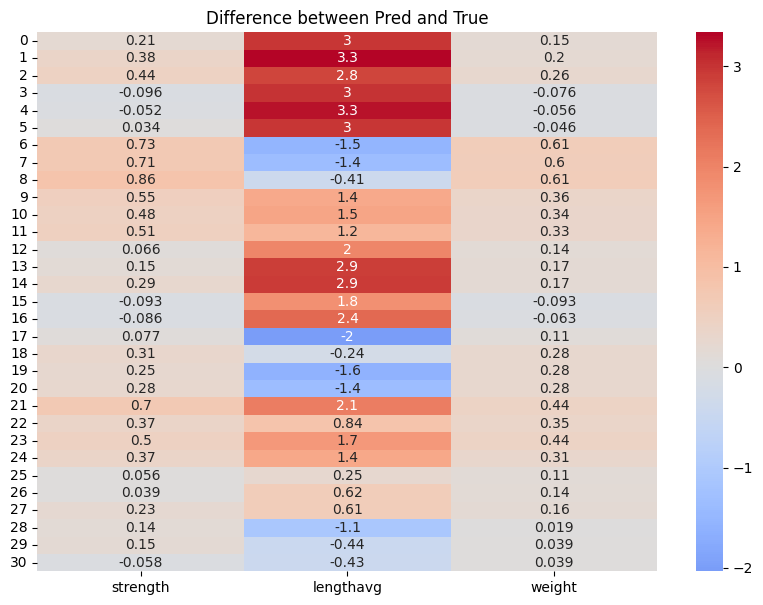

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_difference(pred, true, cols):
    # Shape와 길이 확인
    assert pred.shape == true.shape, "The shape of pred and true arrays should be the same"
    assert len(cols) == pred.shape[1], "Number of columns should match the shape of the arrays"

    # 차이 계산
    diff = np.array(pred) - np.array(true)

    # heatmap으로 차이 표시
    plt.figure(figsize=(10, 7))
    sns.heatmap(diff, annot=True, cmap='coolwarm', center=0, xticklabels=cols)
    plt.title("Difference between Pred and True")
    plt.show()

visualize_difference(test_predictions, test_labels, output_params)

# 단순 오차 계산

In [34]:
def make_martrix(result: pd.DataFrame, names):
    columns = list(result.columns)
    errors={names[0]:0,names[1]:0,names[2]:0}
    for name in names:
        select = [item for item in columns if name in item] # 0 이 예측 1이 실제 
        temp = abs((result[select[1]]-result[select[0]])/result[select[1]])
        errors[name] = temp.mean()*100
    return pd.DataFrame([errors])

data = compare_arrays_with_dataframe(test_predictions, test_labels, output_params)
make_martrix(data, output_params)

,strength,lengthavg,weight
0,30.062549,79.743949,18.34453
